In [1]:
import pandas as pd
import numpy as np # linear algebra
import seaborn as sns
import matplotlib.pyplot as plt
import base64
import string
import re
from collections import Counter
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

In [25]:
df = pd.read_csv('slavic_aa_data.csv')
df.head()

,Unnamed: 0,file,class,text
0,0,journalarticle10.2307_4211795,slavic,natal ia tolstaia natal ia tolstaia some nabok...
1,1,journalarticle10.2307_4380175,slavic,e sharpe inc e sharpe inc e sharpe inc e sharp...
2,2,journalarticle10.2307_3090489,slavic,decollectivization bulgaria hungary decollecti...
3,3,journalarticle10.2307_40650366,slavic,pp price unknown pp price unknown pp price unk...
4,4,journalarticle10.2307_40297132,slavic,copyright act 1912 copyright act 1912 copyrigh...


In [4]:
df.shape

(99209, 4)

In [5]:
# drop any entries without text
df = df.dropna(subset=['text'])

In [6]:
df.isnull().sum()

Unnamed: 0    0
file          0
class         0
text          0
dtype: int64

In [7]:
df['class'].nunique()

2

In [8]:
slavic = df[df['class'] == 'slavic']
aa_studies = df[df['class'] == 'africanamerican']


In [19]:
# downsample so that the kernel does not crash with 60G of RAM
type_ = 'number'
if type_ == 'percent':
    sample = 1.0
    slavic_sample = slavic.sample(n=int(len(slavic) * sample), random_state=1)
    aa_sample = aa_studies.sample(n=int(len(aa_studies) * sample), random_state=1)
if type_ == 'number':
    slavic_sample = slavic.sample(n=10, random_state=1)
    aa_sample = aa_studies.sample(n=10, random_state=1)

print(len(slavic_sample), len(aa_sample))

10 10


In [20]:
df = pd.concat([slavic_sample,aa_sample])
len(df)

20

In [11]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.33, random_state=42)

In [25]:
print('Research title sample:', train['file'].iloc[0])
print('Conference of this paper:', train['class'].iloc[0])
print('Training Data Shape:', train.shape)
print('Testing Data Shape:', test.shape)

Research title sample: journalarticle10.2307_2500768
Conference of this paper: slavic
Training Data Shape: (3321, 4)
Testing Data Shape: (1636, 4)


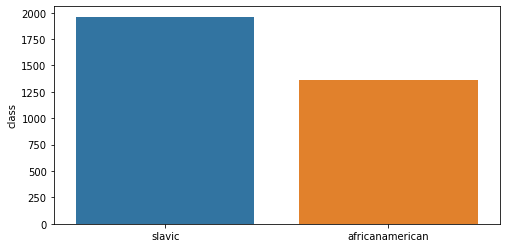

In [26]:
fig = plt.figure(figsize=(8,4))
sns.barplot(x = train['class'].unique(), y=train['class'].value_counts())
plt.show()

In [7]:
import spacy

nlp = spacy.load('xx_ent_wiki_sm')
punctuations = string.punctuation

# Define function to cleanup text by removing personal pronouns, stopwords, and puncuation
def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [8]:
INFO_text = [text for text in train[train['class'] == 'slavic']['file']]

IS_text = [text for text in train[train['class'] == 'africanamerican']['file']]

INFO_clean = cleanup_text(INFO_text)
INFO_clean = ' '.join(INFO_clean).split()

IS_clean = cleanup_text(IS_text)
IS_clean = ' '.join(IS_clean).split()

INFO_counts = Counter(INFO_clean)
IS_counts = Counter(IS_clean)

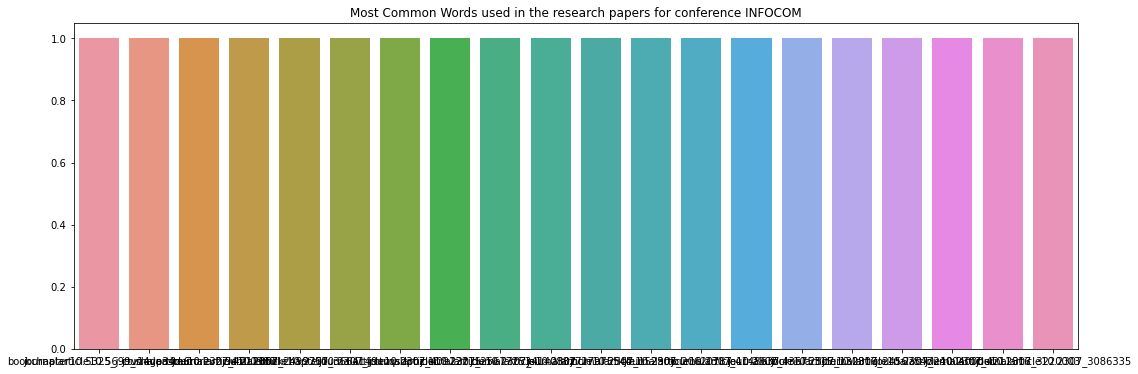

In [9]:
INFO_common_words = [word[0] for word in INFO_counts.most_common(20)]
INFO_common_counts = [word[1] for word in INFO_counts.most_common(20)]

fig = plt.figure(figsize=(18,6))
sns.barplot(x=INFO_common_words, y=INFO_common_counts)
plt.title('Most Common Words used in the research papers for conference INFOCOM')
plt.show()

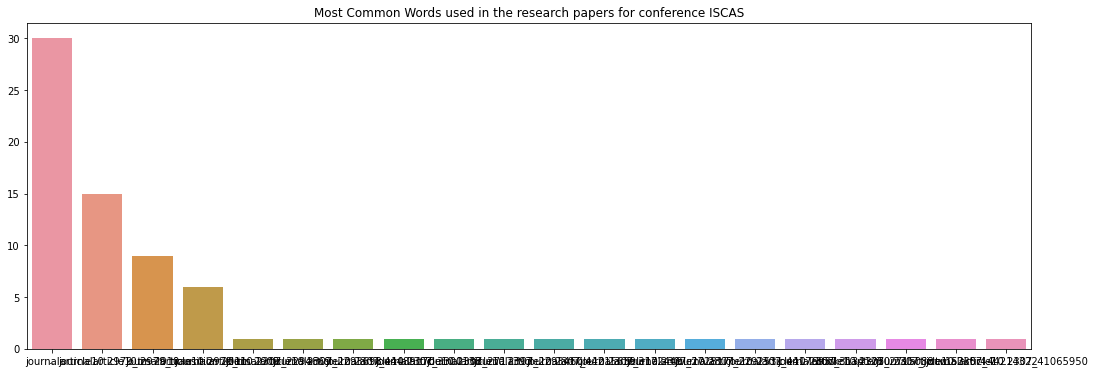

In [10]:
IS_common_words = [word[0] for word in IS_counts.most_common(20)]
IS_common_counts = [word[1] for word in IS_counts.most_common(20)]

fig = plt.figure(figsize=(18,6))
sns.barplot(x=IS_common_words, y=IS_common_counts)
plt.title('Most Common Words used in the research papers for conference ISCAS')
plt.show()

In [11]:
test.head()

,Unnamed: 0,file,class,text
38760,38760,journalarticle10.2307_24003181,slavic,bild vom häßlichen bild vom häßlichen bild vom...
87036,87036,journalarticle10.2307_44245649,africanamerican,civil rights bill civil rights bill civil righ...
22509,22509,journalarticle10.2307_3086154,slavic,cambridge university press cambridge universit...
44723,44723,bookchapter10.2307_j.ctv11692bm.6,africanamerican,der neuen welt der neuen welt der neuen welt d...
69780,69780,journalarticle10.2307_2962972,africanamerican,i i i i i i i i i i i i i i i i i i i i i afri...


In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
import string
import re
import spacy
spacy.load('en_core_web_sm')
from spacy.lang.en import English
parser = English()

/home/ajanco/anaconda3/envs/spacy/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [13]:
STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS))
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”"]

In [14]:
class CleanTextTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        return [cleanText(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    def get_params(self, deep=True):
        return {}
    
def cleanText(text):
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = text.lower()
    return text

def tokenizeText(sample):
    tokens = parser(sample)
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas
    tokens = [tok for tok in tokens if tok not in STOPLIST]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    return tokens

In [15]:
def printNMostInformative(vectorizer, clf, N):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    topClass1 = coefs_with_fns[:N]
    topClass2 = coefs_with_fns[:-(N + 1):-1]
    print("Class 1 best: ")
    for feat in topClass1:
        print(feat)
    print("Class 2 best: ")
    for feat in topClass2:
        print(feat)

vectorizer = CountVectorizer(tokenizer=tokenizeText, ngram_range=(1,1))
clf = LinearSVC()
pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer), ('clf', clf)])

# data
train1 = train['file'].tolist()
labelsTrain1 = train['class'].tolist()

test1 = test['file'].tolist()
labelsTest1 = test['class'].tolist()
# train
pipe.fit(train1, labelsTrain1)

# test
preds = pipe.predict(test1)
print("accuracy:", accuracy_score(labelsTest1, preds))
print("Top 10 features used to predict: ")

printNMostInformative(vectorizer, clf, 10)

pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer)])
transform = pipe.fit_transform(train1, labelsTrain1)
vocab = vectorizer.get_feature_names()

for i in range(len(train1)):
    s = ""
    indexIntoVocab = transform.indices[transform.indptr[i]:transform.indptr[i+1]]
    numOccurences = transform.data[transform.indptr[i]:transform.indptr[i+1]]
    for idx, num in zip(indexIntoVocab, numOccurences):
        s += str((vocab[idx], num))

accuracy: 0.5832798802651272
Top 10 features used to predict: 
Class 1 best: 
(-0.5980386381219308, '..')
(-0.5540630788128413, 'journalarticle10.2307_2291859')
(-0.5540595584194506, 'journalarticle10.2307_1214376')
(-0.5540570536243514, 'journalarticle10.2307_25073648')
(-0.5540568213727057, 'journalarticle10.2307_41069680')
(-0.5540563948544721, 'journalarticle10.2307_2934526')
(-0.5540563515976986, 'journalarticle10.2307_2904421')
(-0.5540563382269069, 'bookchapter10.2307_j.ctvx0707t.11')
(-0.5540554603752081, 'journalarticle10.2307_41069664')
(-0.5540554178988373, 'journalarticle10.2307_272813')
Class 2 best: 
(0.7792856254292021, 'journalarticle10.2307_26627736')
(0.779285492353212, 'journalarticle10.2307_24002811')
(0.7792841719939869, 'journalarticle10.2307_24002894')
(0.779283393705652, 'journalarticle10.2307_308586')
(0.7792820503602158, 'journalarticle10.2307_131216')
(0.7792820451464407, 'journalarticle10.2307_3664379')
(0.7792818684642661, 'journalarticle10.2307_3649991')
(

In [16]:
from sklearn import metrics
print(metrics.classification_report(labelsTest1, preds, 
                                    target_names=df['class'].unique()))

                 precision    recall  f1-score   support

         slavic       0.58      1.00      0.74     19097
africanamerican       0.00      0.00      0.00     13642

       accuracy                           0.58     32739
      macro avg       0.29      0.50      0.37     32739
   weighted avg       0.34      0.58      0.43     32739



In [21]:
import scattertext as st

nlp = spacy.load('xx_ent_wiki_sm',disable_pipes=["tagger","ner"])
nlp.max_length = 5122600
nlp.add_pipe(nlp.create_pipe('sentencizer'))
train_df = df
train_df['parsed'] = train_df.text.apply(nlp)
corpus = st.CorpusFromParsedDocuments(train_df,
                             category_col='class',
                             parsed_col='parsed').build()

In [22]:
print(list(corpus.get_scaled_f_scores_vs_background().index[:100]))

['oprichnina', 'afric', 'raskolnikov', 'muscovite', 'filipp', 'arkhiv', 'iakhin', 'lizaveta', 'literaturen', 'afri', 'slimness', 'obra', 'oprichniki', 'wollmans', 'svidrigailov', 'muscovy', 'luzhin', 'staritskii', 'slawischen', 'gosudarstvennyi', 'riazan', 'insurrections', 'scottsboro', 'hbcu', 'oblasti', 'privateers', 'novgorod', 'dostoevsky', 'pushkin', 'mekhlis', 'tsentral', 'devlet', 'russie', 'aptheker', 'rtskhidni', 'nyi', 'thinness', 'wollman', 'hebdon', 'munitsipal', 'uriupin', 'perestroika', 'boyars', 'negroes', 'xvif', 'rgae', 'girei', 'moskvy', 'russe', 'moskoff', 'kurskoi', 'historiens', 'ivanovna', 'boyar', 'ivan', 'riazanskoi', 'viskovatyi', 'norrgard', 'livonian', 'noblesse', 'revolts', 'konorev', 'eshu', 'sovet', 'cherkasskii', 'zubkova', 'springerj', 'ibler', 'appanage', 'commissariat', 'spriggs', 'jarrell', 'moscou', 'xvie', 'akopian', 'russes', 'tsars', 'historiques', 'insurrection', 'chis', 'sagesse', 'underweight', 'razumihin', 'peschio', 'marmeladov', 'xvne', 'che

In [23]:
import pprint 
term_freq_df = corpus.get_term_freq_df()
term_freq_df['Slavic'] = corpus.get_scaled_f_scores('slavic')
pprint.pprint(list(term_freq_df.sort_values(by='Slavic', ascending=False).index[:100]))

['moscow',
 'policy',
 'ivan s',
 'est',
 'cooperatives',
 'vladimir',
 'oprichnina',
 'pushkin',
 'filipp',
 'stalin',
 'muscovite',
 'novgorod',
 'lizaveta',
 'raskolnikov',
 'und',
 'postwar',
 'dostoevsky',
 'cooperative',
 'slavic',
 'von',
 'qui',
 'der',
 'den',
 'dans',
 'que',
 'privateers',
 'soviet',
 'russian',
 'à',
 'les',
 'le',
 'ivan',
 'market',
 'arkhiv',
 'par',
 'zu',
 'iakhin',
 'tax',
 'russia',
 'mar',
 'des',
 'auch',
 'muscovy',
 'literaturen',
 'nyi',
 'cloth',
 'gentry',
 'de l',
 '1947',
 '1 d',
 'auf',
 'siècle',
 'sector',
 'rubles',
 'à la',
 'gosudarstvennyi',
 'luzhin',
 'une',
 'russie',
 'pour',
 'il',
 'als',
 'oprichniki',
 'terror',
 'wollmans',
 'mar iakhin',
 'tsar',
 'russe',
 'sont',
 'oblasti',
 'royal',
 'charity',
 'svidrigailov',
 'decree',
 'artisans',
 '1566',
 'plus',
 'seventeenth',
 'staritskii',
 'd op',
 'slawischen',
 'perestroika',
 'sixteenth',
 'ussr',
 'sexual',
 'ces',
 'entre',
 'riazan',
 'wollman',
 'metropolitan',
 'se',
 

In [24]:
html = st.produce_scattertext_explorer(
    corpus,
    category='slavic', category_name='slavic', not_category_name='africanamerican',
    minimum_term_frequency=0, pmi_threshold_coefficient=0,
    width_in_pixels=1000, metadata=corpus.get_df()['file'],
    transform=st.Scalers.dense_rank
)
open('./demo_compact.html', 'w').write(html)

33852630

In [38]:
import pprint 
term_freq_df = corpus.get_term_freq_df()
term_freq_df['AfricanAmerican'] = corpus.get_scaled_f_scores('africanamerican')
pprint.pprint(list(term_freq_df.sort_values(by='AfricanAmerican', ascending=False).index[:100]))

['moocs',
 'afro american',
 'african american',
 'haiti',
 'bismarck',
 'dominican',
 'wir',
 'luperon',
 'gott',
 'u ber',
 'hatte',
 'juden',
 'hbcu',
 'jazz',
 'black women',
 'mississippi',
 'nabrit',
 'whites',
 'blacks',
 'afric',
 'hbcus',
 'betances',
 'ava',
 'overweight',
 'johnnie',
 'negro',
 'untergang',
 'rung',
 'negroes',
 'afro',
 'bathing',
 'rhodesia',
 'africans',
 'howard',
 'angst',
 'cleage',
 'blues',
 'pequena',
 'journal negro',
 'wissenschaft',
 'aufkla',
 'angra',
 'puerto',
 'menschheit',
 'cit p',
 'ruby',
 'judentum',
 'gunn',
 'fru',
 'adolescents',
 'r die',
 'rustin',
 'bmi',
 'herron',
 'negro history',
 'afri',
 'granville',
 'races',
 'afric obra',
 'harlem',
 'gates',
 'cobra',
 'spinoza',
 'american literature',
 'body image',
 'damon',
 'idlewild',
 'sudanese',
 'die juden',
 'bathing beauty',
 'achebe',
 'hurston',
 'aa women',
 'negro education',
 'banneker',
 'angra pequena',
 'ende',
 'ahnung',
 'african americans',
 'louisiana',
 'american 

# Use spaCy classifier given poor performance of SVM

In [2]:
import pandas as pd 
df = pd.read_csv('slavic_aa_data.csv')
df = df.dropna(subset=['text'])

In [3]:
from tqdm.autonotebook import tqdm 
TRAIN_DATA = []
for index, row in tqdm(df.iterrows()):
    if row['class'] == 'slavic':
        
        TRAIN_DATA.append((row['text'],{'cats': {'SLAVIC': 1, 'AFRICANAMERICAN': 0}}))
    if row['class'] == 'africanamerican':
        TRAIN_DATA.append((row['text'],{'cats': {'SLAVIC': 0, 'AFRICANAMERICAN': 1}}))

#TRAIN_DATA = [(Text1, {'cats': {'POSITIVE': 1}}),(Text2, {'cats': {'POSITIVE': 0}})]


/home/ajanco/anaconda3/envs/spacy/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """Entry point for launching an IPython kernel.


In [5]:
import spacy 
nlp = spacy.load('xx_ent_wiki_sm')
if 'textcat' not in nlp.pipe_names:
  textcat = nlp.create_pipe("textcat")
  nlp.add_pipe(textcat, last=True) 
else:
  textcat = nlp.get_pipe("textcat")

textcat.add_label('SLAVIC')
textcat.add_label('AFRICANAMERICAN')

1

In [ ]:
from spacy.util import minibatch, compounding

other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']

n_iter = 1

# Only train the textcat pipe
with nlp.disable_pipes(*other_pipes):
    optimizer = nlp.begin_training()
    print("Training model...")
    for i in range(n_iter):
        losses = {}
        batches = minibatch(TRAIN_DATA, size=compounding(4,32,1.001))
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, sgd=optimizer,
                      drop=0.2, losses=losses)

Training model...
